In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from IPython.display import Image as pcs,display, update_display

2024-07-30 14:41:19.217755: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#load images from folder
#augment images with transforms here :)
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

train_generator = train_datagen.flow_from_directory("./training",target_size=(300,300),class_mode='binary')

#validation data, used while training
validation_datagen = ImageDataGenerator(rescale=1/255)
validation_generator = train_datagen.flow_from_directory(
    "./validation",
    target_size=(300,300),
    class_mode='binary',
)

#callback to stop training when 80% accuracy reached on validation set
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('val_accuracy')>0.80):
            print("\nAccuracy reached 80%, stopping training")
            self.model.stop_training = True
callbacks = myCallback()

Found 80 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [3]:
#create model
model = tf.keras.models.Sequential([
    #a bunch of convolution and pooling layers to filter down the image to essential features (hopefully)
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300,300,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    #dropout for regularization (this really impacted model performance)
    tf.keras.layers.Dropout(0.2),
    #sigmoid drives values towards 0 and 1 for binary classification problems
    tf.keras.layers.Dense(1,activation='sigmoid'),
])
model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 298, 298, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 149, 149, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 147, 147, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 33, 33, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,606,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,704,097 (6.50 MB)

 Trainable params: 1,704,097 (6.50 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
#compile model with rmsprop optimizer
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

In [5]:
#train model
history = model.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4807 - loss: 0.6901 - val_accuracy: 0.5000 - val_loss: 0.6796
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5667 - loss: 0.9619 - val_accuracy: 0.5000 - val_loss: 0.7042
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5039 - loss: 0.6988 - val_accuracy: 0.5000 - val_loss: 0.6857
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 954ms/step - accuracy: 0.5323 - loss: 0.6866 - val_accuracy: 0.6000 - val_loss: 0.6919
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6135 - loss: 0.7003 - val_accuracy: 0.5000 - val_loss: 0.6826
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5320 - loss: 0.6879 - val_accuracy: 0.5000 - val_loss: 0.6775
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 975ms/step - accuracy: 0.5586 - loss: 0.6847 - val_accuracy: 0.5500 - val_loss: 0.6859
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 983ms/step - accuracy: 0.6349 - loss: 0.6820 - val_accuracy: 0.5000 - val_loss: 0.6728
Epoch 9/20
3/3 ━━━

In [6]:
#test on custom images
img = image.load_img("./custom/visible/2.png", target_size=(300,300))
x = image.img_to_array(img)
x = np.expand_dims(x,axis=0)

image_tensor = np.vstack([x])
classes = model.predict(image_tensor)

print(train_generator.class_indices)
print(classes)
if classes[0]>0.5:
    print("is visible")
else:
    print("is not visible")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
{'not_visible': 0, 'visible': 1}
[[0.9999994]]
is visible


In [ ]:
#save model to disk
model.save("SecurityModel.keras")

In [7]:
#load it and create a single function that takes a file and outputs a prediction
loaded_model = tf.keras.models.load_model('SecurityModelFinal.keras')

def classify(imgPath):
    #preprocess image into tensor
    if type(imgPath) is str:
        img = image.load_img(imgPath, target_size=(300,300))
    else:
        img = cv2.resize(imgPath, (300, 300))
    x = image.img_to_array(img)
    x = np.expand_dims(x,axis=0)
    tensor = np.vstack([x])
    #classify tensor
    classes = model.predict(tensor)
    if classes[0]>0.5:
        print("model prediction: is visible")
        return True
    else:
        print("model prediction: is not visible")
        return False

In [8]:
#use loaded_model
classify("custom/visible/3.png")
classify("custom/not_visible/5.png")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
model prediction: is visible
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
model prediction: is not visible


False

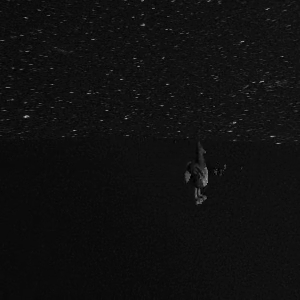

'INTRUDER'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
model prediction: is visible
1 True
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
model prediction: is not visible
5 False
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
model prediction: is not visible
10 False
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
model prediction: is not visible
15 False
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
model prediction: is not visible
20 False
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
model prediction: is not visible
25 False
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
model prediction: is not visible
30 False
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
model prediction: is not visible
35 False
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
model prediction: is not visible
40 False
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
model prediction: is not visible
45 False
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
model prediction: is not visible
50 False
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
model prediction: is not visible
55 False
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
model pre

In [10]:
#Take video input and use the model to determine if an intruder exists
#intruder = False
#video -> frames -> model(frame)
#if model(frame) == visible:
#intruder = True
#else:
#continue
#return intruder

vid = cv2.VideoCapture("./out.mp4")
count = 0
t = "INTRUDER"
f = ""
while(vid.isOpened()):
    ret, frame = vid.read()
    if ret == True:
        if count%5 == 0 or count == 1:
            test = classify(frame)
            print(count,test)
        _,buffer = cv2.imencode('.png',frame)
        if count == 0:
            display(pcs(data=buffer.tobytes()),display_id="fps",clear=True)
            display(t if test else f,display_id="msg")
        else:
            update_display(pcs(data=buffer.tobytes()),display_id="fps")
            update_display(t if test else f,display_id="msg")
        count += 1
    else:
        break
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
vid.release()